# QAOA Implementation: Time to Solution vs. Condition Number

### Description

We seek to solve the "quantum linear systems problem" (QLSP) defined by the system

\begin{equation}
    A \mathbf{x} = \mathbf{b}
\end{equation}

where $A \in \mathbb{R}^{N \times N}$ and $N = 2^n$. QLSP is similar to the classical linear systems problem except we only want to output a "quantum description" of the solution

\begin{equation}
    | \mathbf{x} \rangle = |A^{-1} \mathbf{b} \rangle
\end{equation}

(because we don't have a good way around this).


This notebook explores the time to solution vs the condition condition number $\kappa$ of the matrix $A$.

In [1]:
"""Imports for the notebook.

Requires:
    numpy
    scipy
    matplotlib
"""
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import expm
from scipy.optimize import minimize

# Set precision for printing
np.set_printoptions(precision=2)

# Defining the linear system of equations

Here, we define the matrix for the linear system of equations. First, we define Pauli $Z$ and the identity $I$ for convenience.

In [2]:
"""Helper function and matrices for defining the linear system."""
# Function for tensor products with arbitrary numbers of terms
def tensor(*args) -> np.ndarray:
    """Returns the tensor product over all matrices in args.
    
    Args:
        Each argument must be a np.ndarray.
    """
    if len(args) <= 0:
        raise ValueError("No arguments provided.")
    args = list(args)
    mat = args.pop(0)
    for term in args:
        mat = np.kron(mat, term)
    return mat

# Define the Pauli X matrix
xmat = np.array([[0, 1],
                 [1, 0]], dtype=np.float32)

# Define the Pauli Z matrix
zmat = np.array([[1, 0],
                 [0, -1]], dtype=np.float32)

# Define the identity matrix
imat = np.identity(2, dtype=np.float32)

In [3]:
"""Quick test for the tensor function."""
assert np.allclose(np.kron(imat, imat), tensor(imat, imat))
assert np.allclose(np.kron(imat, zmat), tensor(imat, zmat))
assert np.allclose(np.kron(zmat, imat), tensor(zmat, imat))
assert np.allclose(np.kron(zmat, zmat), tensor(zmat, zmat))

We can now determine a matrix in terms of $\kappa$:

In [4]:
"""Define a function to get the linear system for a given condition number kappa."""
def matrix(kappa: float) -> np.ndarray:
    """Returns the matrix A defined above as a function of kappa.
    
    Args:
        kappa : float
            Condition number of matrix. (Must be greater than or equal to zero.)
    """
    # Overall coefficient for matrix
    coeff = 1 / 4 / kappa
    
    # Define the terms in the system
    term1 = 2.0 * (kappa + 1.0) * tensor(imat, imat, imat)
    term2 = (kappa - 1.0) * tensor(imat, imat, zmat)
    term3 = (kappa - 1.0) * tensor(imat, zmat, imat)
    
    # Return the matrix
    return coeff * (term1 + term2 + term3)

In [5]:
"""Quick test for the matrix function."""
for kappa in range(1, 1000):
    assert np.isclose(np.linalg.cond(matrix(kappa)), kappa)

Finally, we define a function for the $b$ vector in terms of the number of qubits. We always use $\mathbf{b} = H^{\otimes n} |0\rangle ^{\otimes n}$ where $n$ is the number of qubits.

In [6]:
"""Define a function to get the b vector."""
def vector(nqubits: int) -> np.ndarray:
    dim = 2**nqubits
    return 1.0 / np.sqrt(dim) * np.ones(dim)

In [7]:
"""Quick test for the vector function."""
for nqubits in range(1, 10):
    assert np.isclose(np.linalg.norm(vector(nqubits), ord=2), 1.0)

## Defining the Hamiltonian for QAOA

We follow the method outlined in [1] to construct our ansatz wavefunction. First, define the projector

\begin{equation}
    P_\mathbf{b}^\perp := I - |\mathbf{b}\rangle \langle \mathbf{b}| .
\end{equation}

Since $P_\mathbf{b}^\perp |\mathbf{b} \rangle = \mathbf{0}$, we have

\begin{equation}
    P_\mathbf{b}^\perp A | \mathbf{x} \rangle = \mathbf{0} .
\end{equation} 

Define $B := P_\mathbf{b}^\perp A$ and the operator

\begin{equation}
    H_f := B^\dagger B = A P_\mathbf{b}^\perp A .
\end{equation} 

The subscript $f$ will become apparent shortly. This operator (Hamiltonian) is:

* Hermitian. 
* positive-semidefinite $\implies$ $|\mathbf{x}\rangle$ is the ground state.

Note that $|\mathbf{x}\rangle$ is the _unique_ ground state since $P_\mathbf{b}^\perp$ is an $N - 1$ dimensional projector.

We now parameterize the linear system $A$ with the schedule

\begin{equation}
    A \mapsto A(t) := (1 - t) I + t A
\end{equation}

for $0 \le t \le 1$ and similarly the Hamiltonian

\begin{equation}
        H(t) := A(t) P_\mathbf{b}^\perp A(t)  .
\end{equation} 

Note that $H(t=1) = H_f$. 

This defines our "driver Hamiltonian" in QAOA, i.e. the unitary operator

\begin{equation}
    U_t(\gamma) = e^{ - i \gamma H(t) }
\end{equation}

We will, for now, take the standard mixer Hamiltonian

\begin{equation}
    V(\beta) = \prod_j e^{ - i \beta X_j} ,
\end{equation}

i.e., a rotation of each qubit about the $x$-axis by $2 \beta$. 

The ansatz wavefunction is thus

\begin{equation}
    |\mathbf{\gamma}, \mathbf{\beta} \rangle := \left[ \prod_{1}^{p} U_{t_i} (\gamma_i) V(\beta_i) \right] H^{\otimes n} |0\rangle^{\otimes n}
\end{equation}

where $n := \log_2 N$. 

We now define the Hamiltonian in code.

In [8]:
"""Define the Hamiltonian."""
def ham(amat: np.ndarray, bvec: np.ndarray, time: float) -> np.ndarray:
    """Returns the Hamiltonian of the linear system Ax = b at time t."""
    # Get the dimension of the system
    dim = len(bvec)
    
    # Get the b projector
    bprojector = np.identity(dim) - np.outer(bvec, bvec)
    
    # Compute the B matrix
    bmat = bprojector @ amat
    
    # Compute the final hamiltonian
    ham_final = bmat.conj().T @ bmat
    
    # Return the Hamiltonian at time t
    return (1.0 - time) * np.identity(dim) + time * ham_final

In [9]:
"""Quick test for the ham function."""
amat = matrix(kappa=10)
bvec = vector(3)
assert np.allclose(ham(amat, bvec, time=0), np.identity(8))
assert np.allclose(ham(amat, bvec, time=0.25), ham(amat, bvec, time=0.25).conj().T)

In [10]:

ham(amat, bvec, time=1.0)

array([[ 0.88, -0.07, -0.07, -0.01, -0.12, -0.07, -0.07, -0.01],
       [-0.07,  0.26, -0.04, -0.01, -0.07, -0.04, -0.04, -0.01],
       [-0.07, -0.04,  0.26, -0.01, -0.07, -0.04, -0.04, -0.01],
       [-0.01, -0.01, -0.01,  0.01, -0.01, -0.01, -0.01, -0.  ],
       [-0.12, -0.07, -0.07, -0.01,  0.88, -0.07, -0.07, -0.01],
       [-0.07, -0.04, -0.04, -0.01, -0.07,  0.26, -0.04, -0.01],
       [-0.07, -0.04, -0.04, -0.01, -0.07, -0.04,  0.26, -0.01],
       [-0.01, -0.01, -0.01, -0.  , -0.01, -0.01, -0.01,  0.01]])

And now we define functions for the driver Hamiltonian and mixer Hamiltonian in QAOA.

In [11]:
"""Define the driver Hamiltonian."""
def driver(gamma: float, amat: np.ndarray, bvec: np.ndarray, time: float) -> np.ndarray:
    """Returns the driver Hamiltonian."""
    # Get the Hamiltonian
    H = ham(amat, bvec, time)
    
    # Return the exponentiated Hamiltonian
    return expm(-1j * gamma * H * kappa)

In [12]:
"""Quick tests for the driver Hamiltonian."""
amat = matrix(kappa=10)
bvec = vector(3)
assert np.allclose(driver(gamma=0.0, amat=amat, bvec=bvec, time=0), np.identity(8))

# Check unitary
driverf = driver(gamma=0.2, amat=amat, bvec=bvec, time=1.0)
assert np.allclose(driverf.conj().T @ driverf, np.identity(8))

In [13]:
"""Define the mixer Hamiltonian."""
def mixer(beta: float) -> np.ndarray:
    # Get the tensor product of Pauli X on each qubit
    xtensor = tensor(xmat, xmat, xmat)
    
    # Return the exponentiated Hamiltonian
    return expm(-1j * beta * xtensor * kappa)

In [14]:
"""Quick tests for the mixer Hamiltonian."""
assert np.allclose(mixer(beta=0.0), np.identity(8))

# Check unitary
mix = mixer(beta=0.5)
assert np.allclose(mix.conj().T @ mix, np.identity(8))

Last, we need to define the initial state $H^{\otimes n} |0\rangle ^{\otimes n}$ for QAOA:

In [15]:
def init_state(nqubits: int) -> np.ndarray:
    """Returns the initial state H|0> for QAOA."""
    dim = 2**nqubits
    return 1.0 / np.sqrt(dim) * np.ones(dim)

In [16]:
"""Quick tests for initial state."""
for nqubits in range(1, 10):
    assert np.isclose(np.linalg.norm(init_state(nqubits), ord=2), 1.0)
    assert len(set(init_state(nqubits))) == 1

## Defining the Ansatz

The following functions will assume the matrix $A$ and vector $\mathbf{b}$ have been defined (to limit the number of arguments).

In [17]:
"""Defining the matrix, vector, and time to get the Hamiltonian, ansatz, and state."""
amat = matrix(kappa=10)
bvec = vector(3)
xclassical = np.linalg.solve(amat, bvec)
time = 1.0
Hf = ham(amat, bvec, 1.0)

In [18]:
"""Print out the classical solution."""
print("Classical solution:")
print(xclassical)

Classical solution:
[0.35 0.64 0.64 3.54 0.35 0.64 0.64 3.54]


In [19]:
def state(gammas: list, betas: list) -> np.ndarray:
    """Returns the state of the computer after the QAOA ansatz is applied with parameters gammas and betas."""
    if len(gammas) != len(betas):
        raise ValueError("Length of gammas must be equal to the length of betas.")
    
    if len(gammas) == 0:
        raise ValueError("Need at least one parameter.")
    
    # Get the first gamma and beta value
    gamma0 = gammas[0]
    beta0 = betas[0]
    
    # Get the first driver and mixer unitaries
    driver0 = driver(gamma0, amat, bvec, time)
    mixer0 = mixer(beta0)
    
    # Get the ansatz after this state
    ansatz = np.dot(driver0, mixer0)
    
    # Do this for all parameters
    for gamma, beta in zip(gammas[1:], betas[1:]):
        drive = driver(gamma, amat, bvec, time)
        mix = mixer(beta)
        
        ansatz = np.dot(ansatz, np.dot(drive, mix))
    
    # Return the ansatz applied to the initial state H|0>
    return np.dot(ansatz, init_state(nqubits=3))

In [20]:
"""Quick tests for the state function."""
assert np.allclose(state([0], [0]), init_state(3))
assert np.allclose(state([0] * 10, [0] * 10), init_state(3))
assert np.isclose(np.linalg.norm(state([1, 2], [3, 4]), ord=2), 1.0, atol=1e-4)
assert np.allclose(state([0, 0, 1], [0, 0, 2]), state([1], [2]))
assert np.allclose(state([0, 0, 1], [0, 0, 2]), state([1, 0, 0, 0], [2, 0, 0, 0]))

## Defining the cost

We now define the cost function for a set of parameters.

In [21]:
"""Defining the cost function."""
def cost(angles: list) -> float:
    """Returns the cost at the given angles, formatted as [gammas, betas]."""
    if len(angles) % 2 != 0:
        raise ValueError("Number of parameters must be even.")
    
    # Get the gammas and betas
    gammas = angles[:len(angles) // 2]
    betas = angles[len(angles) // 2:]
    
    # Get the state
    psi = state(gammas, betas)
    
    # Compute the overlap
    overlap = abs(np.dot(psi.conj().T, xclassical))**2 / np.dot(xclassical, xclassical)
    
    # Compute the cost to minimize
    obj = 1.0 - overlap
    
    # Display it to the console
    print("Current cost:", obj, end="\r")
    
    # Return the cost
    return obj

## Define gradient minimizer

In [22]:
"""Defining a gradient optimizer."""
# Result class for optimization results
class Result:
        def __init__(self, fval, nfev, nit, x, tol):
            self.fval = fval
            self.nfev = nfev
            self.nit = nit
            self.x = x
            self.success = fval < tol

# Function to perform gradient optimization
def vqgd(obj, x, eta=0.5, tol=1e-2, maxit=300, maxfev=1000):
    """Variational quantum gradient descent minimizer."""
    # Number of parameters
    nparams = len(x)
    
    # Iteration counter
    it = 0
    
    # Function evaluation counter
    nfev = 0
    
    while obj(x) > tol and it < maxit and nfev < maxfev:
        
        for ii in range(nparams):
            # ======================
            # Compute the derivative
            # ======================
            
            # Copy current parameters
            xplus = deepcopy(x)
            xminus = deepcopy(x)
            
            # Shift by plus/minus pi / 2
            xplus[ii] += np.pi / 2
            xminus[ii] -= np.pi / 2
            
            # Compute the derivative
            deriv = 0.5 * (obj(xplus) - obj(xminus))
            
            # ====================
            # Update the parameter
            # ====================
            
            x[ii] += eta * deriv
        
        # Increment the counters
        it += 1
        nfev += 1 + 2 * nparams
    
    return Result(obj(x), nfev, it, x, tol)

## Do the minimization

In [23]:
"""Do the minimization for a particular matrix using scipy.optimize.minimize."""
# Define the system
kappa = 1000
amat = matrix(kappa)
bvec = vector(3)
xclassical = np.linalg.solve(amat, bvec)
time = 1.0

# Random set of initial parameters
x0 = np.random.randn(10)

# Do the minimization
out = minimize(cost, x0, method="COBYLA", tol=1e-7)

print()
print("nfev =", out.nfev)
print("obj =", out.fun)

Current cost: 0.020637756093326742
nfev = 273
obj = 0.020637756093326742


In [32]:
"""Define functions to return the final state and overlap with classical solution.

REQUIRES: Output of scipy.optimize.minimize to be named `out`.
"""
def final_state(out):
    return state(out.x[:len(out.x) // 2], out.x[len(out.x) // 2: ])

def final_overlap(out):
    return abs(np.dot(final_state(out), xclassical))**2 / np.dot(xclassical, xclassical)

In [33]:
print("Final overlap:", final_overlap(out))

Final overlap: 0.9634208227010037


## Do the minimization while varying kappa

In [97]:
"""Some constants and hyperparameters."""
# Number of trials to do at each kappa value
NUM_TRIALS = 50

# Minimum fidelity to consider a solution
MIN_FIDELITY = 0.95

# Kappa values to consider
kappas = np.linspace(1, 1000, 50)

# Number to average over
SHOTS = 10

VERBOSE = False

In [109]:
"""Do the minimization while varying kappa."""
# Some constants which define the system
bvec = vector(3)
time = 1.0

allfevs = []
alltrials = []

for ii in range(SHOTS):
    
    print("Shot #", ii, "\n========\n")

    # List to store overall number of function evaluations
    nfevs = []

    # List to store number of trials
    trials = []

    # Loop over the kappa values
    for kappa in kappas:
        # Status update
        print("Status: kappa =", kappa)
        
        # Define the system
        amat = matrix(kappa)

        # Get the classical solution
        xclassical = np.linalg.solve(amat, bvec)

        # Do ten trials at this kappa value
        for trial in range(NUM_TRIALS):
            # Random set of initial parameters
            x0 = np.random.randn(10)

            # Do the minimization
            out = minimize(cost, x0, method="COBYLA")

            if final_overlap(out) >= MIN_FIDELITY:
                if VERBOSE:
                    print()
                    print("kappa = {} completed in {} trial(s).".format(kappa, trial + 1))
                    print("fidelity =", final_overlap(out))
                    print()
                nfevs.append(out.nfev)
                trials.append(trial + 1)
                break

    allfevs.append(nfevs)
    alltrials.append(trials)

Shot # 0
Status: kappa = 1.0
Status: kappa = 21.387755102040817-07
Status: kappa = 41.77551020408163456
Status: kappa = 62.1632653061224545
Status: kappa = 82.551020408163279
Status: kappa = 102.938775510204082
Status: kappa = 123.326530612244916
Status: kappa = 143.71428571428572
Status: kappa = 164.102040816326546
Status: kappa = 184.489795918367354
Status: kappa = 204.877551020408167
Status: kappa = 225.265306122448985
Status: kappa = 245.65306122448982
Status: kappa = 266.0408163265306504
Status: kappa = 286.428571428571444
Status: kappa = 306.81632653061223
Status: kappa = 327.20408163265315
Status: kappa = 347.59183673469395
Status: kappa = 367.979591836734743
Status: kappa = 388.36734693877554
Status: kappa = 408.75510204081632
Status: kappa = 429.14285714285717
Status: kappa = 449.53061224489795
Status: kappa = 469.91836734693884
Status: kappa = 490.30612244897964
Status: kappa = 510.69387755102045
Status: kappa = 531.08163265306124
Status: kappa = 551.46938775510233
Status: ka

Status: kappa = 592.24489795918374
Status: kappa = 612.63265306122455
Status: kappa = 633.02040816326533
Status: kappa = 653.40816326530616
Status: kappa = 673.79591836734744
Status: kappa = 694.18367346938787
Status: kappa = 714.57142857142862
Status: kappa = 734.9591836734694
Status: kappa = 755.34693877551025
Status: kappa = 775.73469387755114
Status: kappa = 796.12244897959186
Status: kappa = 816.51020408163276
Status: kappa = 836.897959183673595
Status: kappa = 857.28571428571435
Status: kappa = 877.67346938775523
Status: kappa = 898.06122448979592
Status: kappa = 918.44897959183676
Status: kappa = 938.83673469387767
Status: kappa = 959.22448979591844
Status: kappa = 979.61224489795935
Status: kappa = 1000.0809257801133
Shot # 5cost: 0.018926026502939508
Status: kappa = 1.0
Status: kappa = 21.387755102040817-07
Status: kappa = 41.77551020408163405
Status: kappa = 62.16326530612245474
Status: kappa = 82.551020408163276
Status: kappa = 102.9387755102040858
Status: kappa = 123.326530

Status: kappa = 143.714285714285724
Status: kappa = 164.10204081632654
Status: kappa = 184.489795918367357
Status: kappa = 204.87755102040816
Status: kappa = 225.26530612244898
Status: kappa = 245.65306122448982
Status: kappa = 266.04081632653063
Status: kappa = 286.42857142857144
Status: kappa = 306.81632653061223
Status: kappa = 327.204081632653125
Status: kappa = 347.59183673469391
Status: kappa = 367.97959183673474
Status: kappa = 388.367346938775546
Status: kappa = 408.75510204081638
Status: kappa = 429.14285714285717
Status: kappa = 449.53061224489795
Status: kappa = 469.91836734693885
Status: kappa = 490.30612244897964
Status: kappa = 510.69387755102047
Status: kappa = 531.08163265306126
Status: kappa = 551.46938775510288
Status: kappa = 571.85714285714291
Status: kappa = 592.244897959183703
Status: kappa = 612.632653061224526
Status: kappa = 633.02040816326536
Status: kappa = 653.40816326530614
Status: kappa = 673.79591836734716
Status: kappa = 694.18367346938784
Status: kappa 

In [110]:
"""Transpose the total trials and total function evaluations."""
tarray = np.array(alltrials)
tarray = tarray.T

farray = np.array(allfevs)
farray = farray.T

In [111]:
"""Extract the average number of function evaluations and the standard deviation over all trials."""
# Lists to store values
tavgs = np.average(tarray, axis=1)
tstds = np.std(tarray, axis=1)
favgs = np.average(farray, axis=1)
fstds = np.std(farray, axis=1)

In [112]:
"""Some plotting options."""
plt.rcParams.update({'font.size': 17, "font.weight": "bold"})

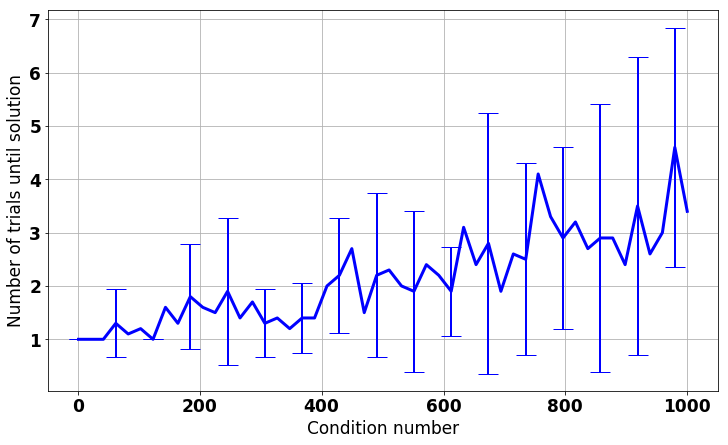

<Figure size 432x288 with 0 Axes>

In [118]:
"""Plot the trial number vs kappa statistics."""
plt.figure(figsize=(12, 7))
plt.errorbar(kappas, tavgs, tstds, ls="-", color="blue", linewidth=3.0, elinewidth=2.0, capsize=10.0, errorevery=3)
plt.grid()
plt.xlabel("Condition number")
plt.ylabel("Number of trials until solution")
plt.show()
# plt.savefig("trial-vs-kappa-statistics-kappa1000-cobyla-10shot-stats2.pdf", format="pdf")

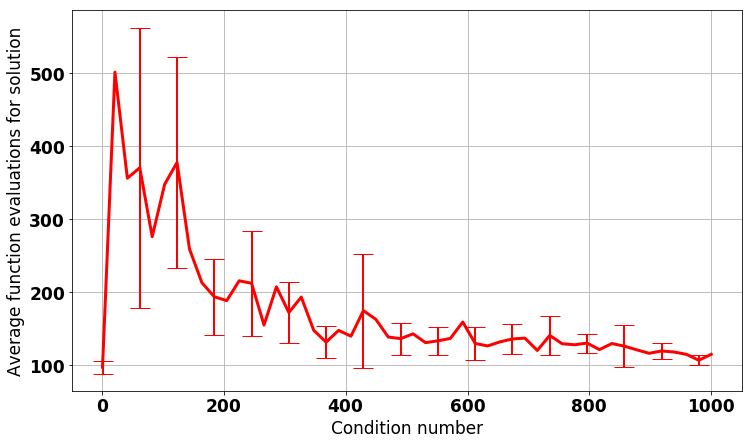

<Figure size 432x288 with 0 Axes>

In [119]:
"""Plot the number of function evaluations vs kappa statistics."""
plt.figure(figsize=(12, 7))
plt.errorbar(kappas, favgs, fstds, ls="-", color="red", linewidth=3.0, elinewidth=2.0, capsize=10.0, errorevery=3)
plt.grid()
plt.xlabel("Condition number")
plt.ylabel("Average function evaluations for solution")
plt.show()
# plt.savefig("fev-vs-kappa-statistics-kappa1000-cobyla-10shot-stats2.pdf", format="pdf")

## Do a grid search

In [ ]:
"""Do a grid search."""
npoints = 100

costs = np.zeros([npoints, npoints])

gammas = np.linspace(0.0, 2.0 * np.pi, npoints)
betas = np.linspace(0.0, 2.0 * np.pi, npoints)

for (ii, gamma) in enumerate(gammas):
    for (jj, beta) in enumerate(betas):
        costs[ii, jj] = cost([gamma, beta])

## References

[1] Yigit Subasi, Rolando D. Somma, Davide Orsucci, Quantum algorithms for systems of linear equations inspired by adiabatic quantum computing. https://arxiv.org/abs/1805.10549.